## Modeling for predicting hospitalization at ED disposition

Flow:
1. task-specific filter: exclude ED death cases for train and test
2. variable selection
3. Modeling script
4. Performance output


### Load train and test

In [46]:
import pandas as pd
import numpy as np
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
import time

path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
#path = '/home/jun/data/MIMIC/mimiciv/1.0/processed'
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 0.95

In [47]:
pd.set_option('display.max_columns', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcomplaint,chiefcom_chest_pain,...,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS,score_SERP2d,score_SERP7d,score_SERP30d
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,3.0,LOWER ABD PAIN,False,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0,97.333333,4,3,1,1,1,16,21,16
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,2.0,Dyspnea,False,...,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0,118.333333,9,8,1,0,1,28,33,29
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,2.0,"ILI, Cough",False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0,116.000000,12,4,4,4,4,18,20,17
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,2.0,"Chest pain, Dyspnea",True,...,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0,100.000000,16,7,5,3,3,36,36,31
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,37.111111,90.0,14.0,99.0,125.0,68.0,3.000000,3.0,Lower back pain,False,...,0,1,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,36.666667,74.000000,18.000000,98.000000,100.000000,59.000000,0.000000,6.0,13.0,87.000000,9,6,0,0,0,32,36,31


In [3]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [48]:
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False]

### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [27]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.9157284785879691 : 1


### 3.  Modeling script

In [63]:
# Containers for all results
result_list = []

In [ ]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



Logistic Regression:


MLP:
Training time: 426.6495010852814 seconds
AUC: 0.8229029426858434
AP(AUPRC): 0.7980580068356845
Sensitivity: 0.7566165993132286
Specificity: 0.729483930054738
Score thresold: 0.4592659603994522


No handles with labels found to put in legend.


Confidence interval for the score: [0.823 - 0.823]


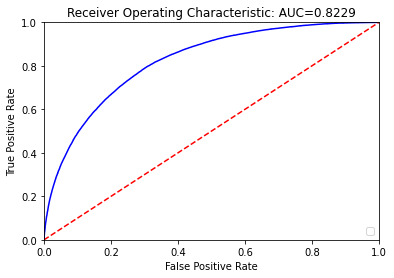

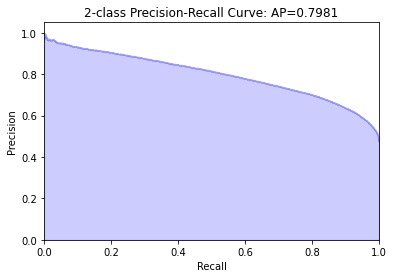

In [12]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


RandomForest:
Training time: 108.75421619415283 seconds
AUC: 0.8194875573983939
AP(AUPRC): 0.7856165869213408
Sensitivity: 0.7411759209512019
Specificity: 0.7469489467742967
Score thresold: 0.5052929292929292


No handles with labels found to put in legend.


Confidence interval for the score: [0.819 - 0.82]


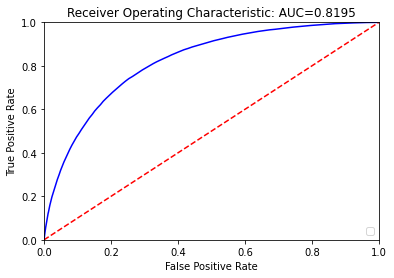

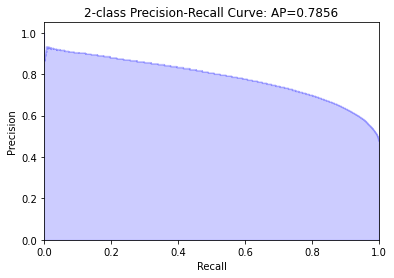

[0.12229835 0.01324033 0.00758834 0.01153722 0.02201601 0.00681918
 0.0155382  0.02615696 0.00076406 0.0016745  0.00549202 0.07798832
 0.08443352 0.03991535 0.04841639 0.08607846 0.08184223 0.0503036
 0.11377595 0.00687364 0.00890328 0.00492228 0.00054841 0.00417139
 0.00280566 0.00382412 0.00424261 0.00336663 0.00409417 0.00313704
 0.00464629 0.00282378 0.002997   0.00144228 0.00636763 0.00216958
 0.00151165 0.00396725 0.00605076 0.00320733 0.00122378 0.00486634
 0.00458783 0.00142337 0.00200586 0.00107421 0.00795443 0.00274561
 0.00247398 0.0059725  0.0109299  0.00454298 0.00423658 0.00095041
 0.00399375 0.00484005 0.00347828 0.01124267 0.00113987 0.0033451
 0.00483549 0.00416227 0.00287257 0.00715043]


In [13]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 109.89546942710876 seconds
AUC: 0.8201969954347942
AP(AUPRC): 0.7957131364850815
Sensitivity: 0.7389801210025929
Specificity: 0.7435837362356499
Score thresold: 0.4940206167731962


No handles with labels found to put in legend.


Confidence interval for the score: [0.820 - 0.82]


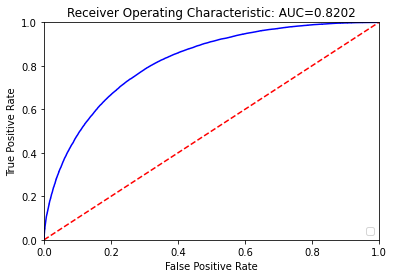

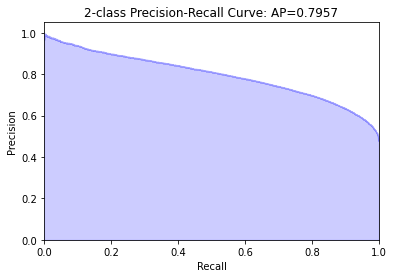

In [14]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [15]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

In [54]:
def get_score_performance(s):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


In [ ]:
df_test["esi"] = -df_test["triage_acuity"]
get_score_performance("esi")

score_NEWS
AUC: 0.5743951007088118
AP(AUPRC): 0.5551390217473994
Sensitivity: 0.5493237403349763
Specificity: 0.5455900832783114
Score thresold: 1


No handles with labels found to put in legend.


Confidence interval for the score: [0.574 - 0.575]


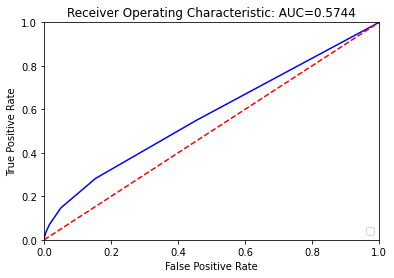

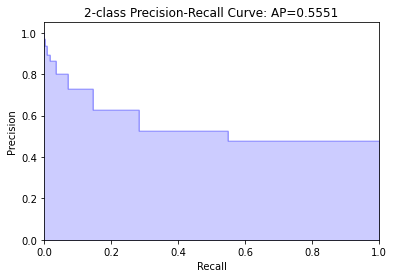

In [55]:
get_score_performance("score_NEWS")

score_NEWS2
AUC: 0.5567351357051066
AP(AUPRC): 0.5382689853343715
Sensitivity: 0.502791469083604
Specificity: 0.5680816170049626
Score thresold: 1


No handles with labels found to put in legend.


Confidence interval for the score: [0.557 - 0.557]


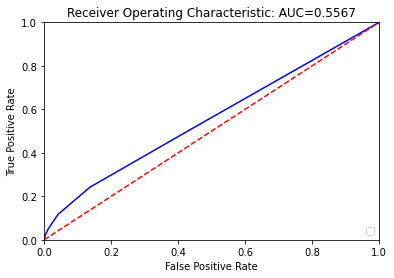

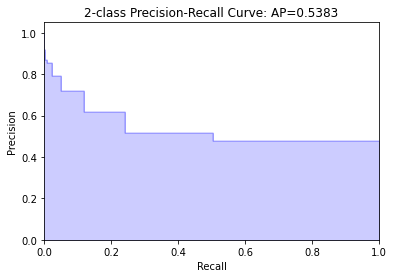

In [56]:
get_score_performance("score_NEWS2")

score_REMS
AUC: 0.6715001298214877
AP(AUPRC): 0.6122906627833825
Sensitivity: 0.7118596556798804
Specificity: 0.5650997848821111
Score thresold: 3


No handles with labels found to put in legend.


Confidence interval for the score: [0.671 - 0.672]


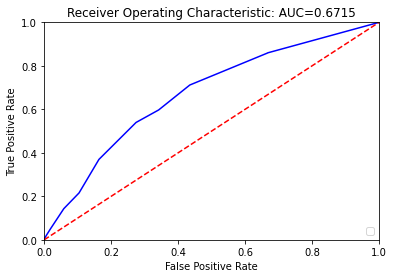

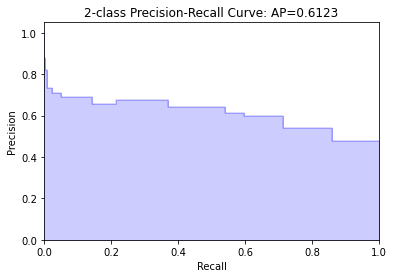

In [57]:
get_score_performance("score_REMS")

score_MEWS
AUC: 0.5573054456894385
AP(AUPRC): 0.5246811307761181
Sensitivity: 0.290242705973043
Specificity: 0.8138271815296798
Score thresold: 2


No handles with labels found to put in legend.


Confidence interval for the score: [0.557 - 0.557]


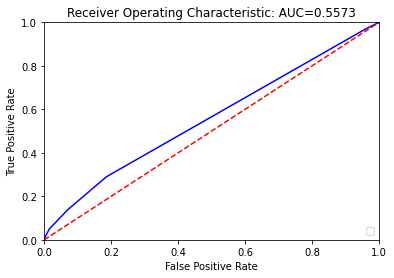

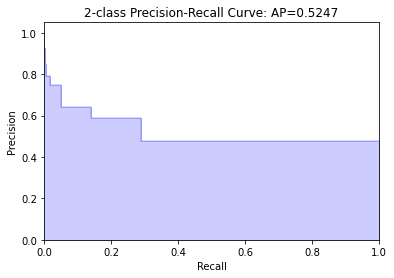

In [58]:
get_score_performance("score_MEWS")

score_CART
AUC: 0.6740959981091517
AP(AUPRC): 0.6199567036795708
Sensitivity: 0.6985914176925413
Specificity: 0.589827692700901
Score thresold: 4


No handles with labels found to put in legend.


Confidence interval for the score: [0.674 - 0.674]


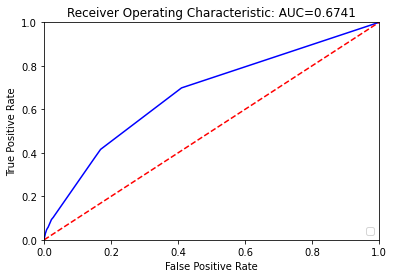

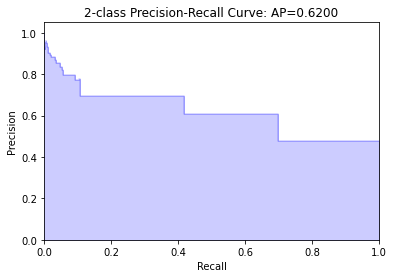

In [59]:
get_score_performance("score_CART")

### 4. Performance output

In [16]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'roc_auc', 'average_precision', 'sensitivity', 'specificity', 'threshold', 'average_precision', 'lower_auroc', 'upper_auroc', 'lower_ap', 'upper_ap', 'lower_sensitivity', 'upper_sensitivity', 'lower_specificity', 'upper_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df.head()

,Model,sensitivity,specificity,threshold,average_precision,lower_auc,roc_auc,upper_auc,runtime
0,LR,0.753720,0.710166,0.442366,0.775517,0.806287,0.806401,0.806441,5.163166
1,MLP,0.756617,0.729484,0.459266,0.798058,0.822790,0.822903,0.822969,426.649501
2,RF,0.741176,0.746949,0.505293,0.785617,0.819392,0.819488,0.819551,108.754216
3,GB,0.738980,0.743584,0.494021,0.795713,0.820116,0.820197,0.820307,109.895469


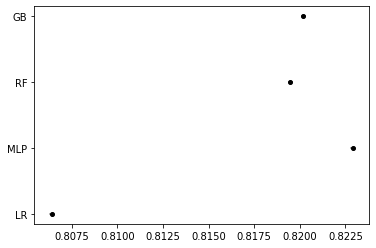

In [17]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df)

In [19]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage.csv'))
importance_df

,Variable,Importance
0,age,0.122298
1,gender,0.013240
2,n_ed_30d,0.007588
3,n_ed_90d,0.011537
4,n_ed_365d,0.022016
...,...,...
59,eci_Anemia,0.003345
60,eci_Alcohol,0.004835
61,eci_Drugs,0.004162
62,eci_Psychoses,0.002873
